# Generate figures from Noori et al. PNAS 2020

This repo's [README](www.github.com/LefebvreLab/ActivityDependentMyelinationModel/README.md) file explains how to compile and run the c++ code in which the myelin plasticity model is implemented. 

In this notebook we pull in the data generated by those simulations and visualize it as is shown in the figures of the paper. 


## Setup

Importage

In [1]:
# Generic imports
import os,sys,glob,numpy as np,pandas as pd
from numpy import pi

# Visualization stuff
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from IPython.display import Image
from IPython.display import clear_output


In [2]:
"""
from matplotlib import rc
rc('text', usetex=False)

import matplotlib

matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['text.latex.unicode']=False#True

from numpy import pi
""";

Define some variables

In [3]:
# Folder with connectivity matrix weights, lengths, and node coordinates
connectivity_data_dir = '../data/connectivity'

# Simulation outputs folder
sim_res_dir = '../data/sim_results'

## Figure 1

In [4]:
# Load the data

f = connectivity_data_dir + '/Lengths96.txt'
L = np.loadtxt(f)

f = connectivity_data_dir + '/Weights96.txt'
W = np.loadtxt(f)

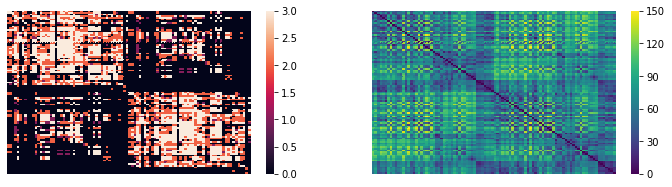

In [5]:
# Plot

fig, ax = plt.subplots(ncols=2, figsize=(12,3))

sns.heatmap(W,ax=ax[0],xticklabels='',yticklabels='');
sns.heatmap(L,cmap='viridis',ax=ax[1],xticklabels='',yticklabels='');

> Figure 1: Whole-brain anatomical connectivity used in the model. The network is composed of 96 nodes, each corresponding to brain regions from the regional map parcellation of Kötter & Wanke (2005)  (see Methods). Region labels are given on the left. A. Matrix of connectivity weights, representing the density of axonal connections between every pair of nodes (arbitrary units). Higher (brighter) values of the connection weights denote denser connections; black entries indicate no anatomical connection for that node pair.   B. Matrix of tract lengths, as approximated by Euclidean distances between the centroids of each area in the (human-modified) regional map parcellation. 

## Figure 3

Filenames

In [6]:
# Input data to create coords file
centres_file = connectivity_data_dir + '/Centres96.txt'

# Create this coords file for plotting   
node_coords_file = connectivity_data_dir + '/node_coords.npy'

# Edges mask file for plotting
mask_file = connectivity_data_dir + '/mask1.npy'

# Post-plasticity data to plot
kcsma_file = sim_res_dir + '/Fig3_Kuramoto_Conduction_speed_matrix_after.txt'

# Create this file with post-plasticity data for plotting
edges_cv_a_file = sim_res_dir + '/cv_after.npy'

# Final post-plasticity network figure
network_cv_b_file = 'Fig3_network_cv_before.png'
network_cv_a_file = 'Fig3_network_cv_after.png'

Visbrain network plotting functions

In [7]:
from visbrain.objects import ConnectObj, SceneObj, SourceObj, BrainObj
from visbrain.config import CONFIG
CONFIG['MPL_RENDER'] = False

def gen_cv_array(fname):
    # cv_after - generating numpy array from text ouput for cv
    # file name read from command line

    df = pd.read_csv(fname, sep = "\t", header=None)
    temp = df.to_numpy()

    cv_after = np.ones((96,96))*-999
    cntr = 0
    for i in range(96):
        for j in range(96):
            cv_after[i,j] = temp[cntr,3]
            cntr= cntr + 1

    #print(np.min(cv_after), np.max(cv_after), cv_after)
    
    return cv_after

# %load /nethome/kcni/jgriffiths/Downloads/PNAS_submission/Fig3/jg_network-fig-code_test/gen_np_data.py

"""
This file generates and saves numpy arrays that are used by 'gen_net_fig.py':

- coords.npy
- mask1.npy
- cv_after.npy - needs name of text file with cv data as command line arg

If using the TVB functions - run this file with Python 2.7.16 :: Anaconda, Inc.
"""

# from tvb.simulator.lab import connectivity
import pandas as pd
import numpy as np
import sys                

#Helper Functions########################################################################

def make_mask_data(mode, data):
    """
    mode is which mask you want:
    1: all-all
    2: cortical-cortical cnxns
    3: subcortico-subcortical cnxns
    4: cortical-subcortical cnxns
    
    data: the array you want to mask
    
    return: array of True/False of shape 'data' - False where you want to keep data and 
    True where you want to mask it
    """
    
    if mode == 1:
        mask = data==0
        return mask
    elif mode ==2:
        mask = np.zeros_like(data)
        for c in cortical_nodes: # set all cortical cnx to True
            mask[c,cortical_nodes] = True
            mask[cortical_nodes,c] = True
        mask = (mask*data!=0)==False # remove the cnx where weight is 0 then turn everything that is True to False
        return mask
    elif mode ==3:
        mask = np.zeros_like(data)
        for c in subcortical_nodes: 
            mask[c,subcortical_nodes] = True
            mask[subcortical_nodes,c] = True
        mask = (mask*data!=0)==False
        return mask
    elif mode ==4:
        mask = np.zeros_like(data)
        for c in cortical_nodes: 
            mask[c,subcortical_nodes] = True
            mask[subcortical_nodes,c] = True
        mask = (mask*weights_j!=0)==False
        return mask
    return


def make_net_fig(edges_data,nodes_data,mask_data,outfile):
    
    # Create the scene with a white background

    #azimuth rotation on horizontal axis
    CAM_STATE = dict(azimuth=0,        # azimuth angle
                     elevation=90,     # elevation angle
                     scale_factor=180  # distance to the camera
                     )

    sc = SceneObj(bgcolor='white', size=(1600, 1000), camera_state=CAM_STATE)

    # Colorbar default arguments. See `visbrain.objects.ColorbarObj`
    CBAR_STATE = dict(cbtxtsz=12, txtsz=10., width=.1, cbtxtsh=3.,
                      rect=(-.3, -2., 1., 4.))
    KW = dict(title_size=14., zoom=1.2)

    # Color by connectivity strength
    # First, we download a connectivity dataset consisting of the location of each
    # node and the connectivity strength between those nodes. The first
    # coloring method illustrated below consist in coloring connections based on
    # a colormap

    # Coloring method
    color_by = 'strength'
    # Because we don't want to plot every connections, we only keep connections
    # above threshold

    #applying mask for diff regions
    edges = np.where(mask_data, -999, edges_data)

    nodes = nodes_data
    #print(edges, edges.shape)

    #diff levels for diff weights
    select0 = edges > 0
    select00 = edges <10
    select_0 = select0 == select00

    select1 = edges > 10
    select11 = edges <20
    select_1 = select1 == select11

    select2 = edges > 20
    select22 = edges <30
    select_2 = select2 == select22

    select3 = edges > 30
    select33 = edges <40
    select_3 = select3 == select33

    select_4 = edges > 40

    ################Different colors for diff strengths
    # Define the connectivity object

    if select_0.any():
        c_default = ConnectObj('default', nodes, edges, select=select_0, line_width=1.5, antialias =True, custom_colors = {None: "#686868"},color_by = color_by, cmap = "inferno")
        sc.add_to_subplot(c_default, row=0, col=0, zoom=0.1)

    if select_1.any():
        c_default1 = ConnectObj('default', nodes, edges, select=select_1, line_width=1.5, antialias =True, custom_colors = {None: "black"},color_by = color_by, cmap = "inferno")
        sc.add_to_subplot(c_default1, row=0, col=0, zoom=0.1)

    if select_2.any():
        c_default2 = ConnectObj('default', nodes, edges, select=select_2, line_width=1.6, antialias =True, custom_colors = {None: "rebeccapurple"},color_by = color_by, cmap = "inferno")
        sc.add_to_subplot(c_default2, row=0, col=0, zoom=0.1)

    if select_3.any():
        c_default3 = ConnectObj('default', nodes, edges, select=select_3, line_width=1.7, antialias =True, custom_colors = {None: "mediumvioletred"},color_by = color_by, cmap = "inferno")
        sc.add_to_subplot(c_default3, row=0, col=0, zoom=0.1)


    if select_4.any():
        c_default4 = ConnectObj('default', nodes, edges, select=select_4, line_width=1.8, antialias =True, custom_colors = {None: "darkorange"},color_by = color_by, cmap = "inferno")
        sc.add_to_subplot(c_default4, row=0, col=0, zoom=0.1)

    # Then, we define the sourcess
    #node size and color
    s_obj = SourceObj('sources', nodes, radius_min=5., color="red")

    # And add source to the scene
    sc.add_to_subplot(s_obj, row=0, col=0, zoom=0.1)

    #fname = os.getcwd() + '/temp.png'

    #sc.screenshot(fname,bgcolor='red',print_size=(1,0.5),dpi=1200,transparent=True,autocrop=True)#,print_size=(10,10))
    sc.screenshot(outfile, print_size=(1,0.5),transparent=True,autocrop=True,dpi=1200)#rint_size=(5,5))

    #io.write_fig_canvas(fname,sc.canvas,print_size=(5,5))



Generate the data for plotting

In [8]:
# Generate the post-plasticity conduction velocities array
ksma_cv_array = gen_cv_array(kcsma_file)
np.save(edges_cv_a_file,ksma_cv_array)
edges_cv_a_data = ksma_cv_array

# pre-plasticity velocities are uniform values
edges_cv_b_data = edges_cv_a_data.copy()
edges_cv_b_data[edges_cv_b_data>0] = 3.
edges_cv_b_data

# Generate the mask
mask_data = make_mask_data(1,ksma_cv_array)
np.save(mask_file, mask_data)

# Generate the node coordinates
df = pd.read_csv(centres_file, sep = " * ", header=None)
node_coords_data = df.to_numpy()
node_coords_data = node_coords_data[:,1:4]
np.save(node_coords_file,node_coords_data)


/nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


Make the figures

In [9]:
make_net_fig(edges_cv_a_data,node_coords_data,mask_data,network_cv_a_file)

make_net_fig(edges_cv_b_data,node_coords_data,mask_data,network_cv_b_file)

clear_output()

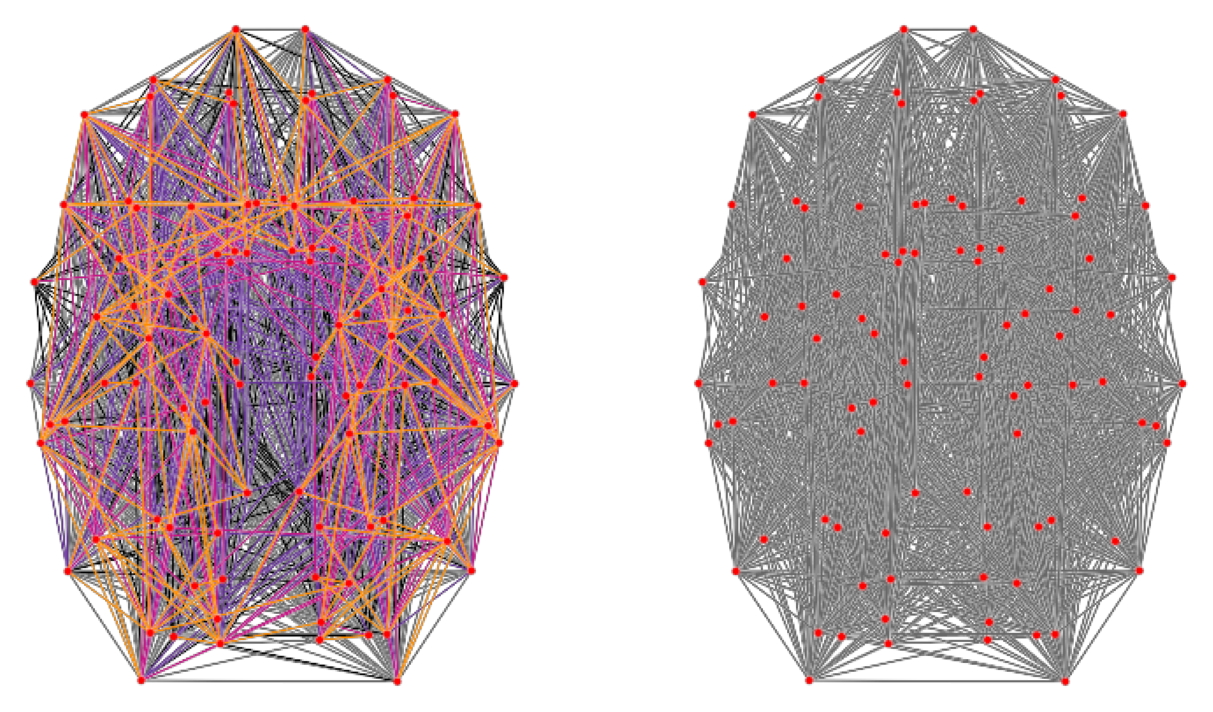

In [10]:
fig, ax = plt.subplots(figsize=(20,10),ncols=2)
ax[0].imshow(plt.imread(network_cv_a_file))
ax[1].imshow(plt.imread(network_cv_b_file))

ax[0].axis('off')
ax[1].axis('off')

plt.tight_layout()

> Figure 3: Spontaneous transition to phase-locked synchrony due to adaptive plastic changes in conduction velocity. A. The network was initially set with uniform conduction velocity and phase were randomized. As a result, the overall dynamics are incoherent and the order parameter r is small. B. After a period of 10h, the conduction velocity along network connections changed and adjusted so that phase-locked synchrony emerges in the system. C. Evolution of randomly selected plastic conduction velocities. Conduction velocities increase and plateau once phase-locking is achieved.  D. Associated time delays as a function of time, showing how fast axonal connections formed over the duration of the simulations. Here g=0.3, ω_o=0.65rad/s = 10Hz, α_c=1x〖10〗^(-4). 

## Figure 5

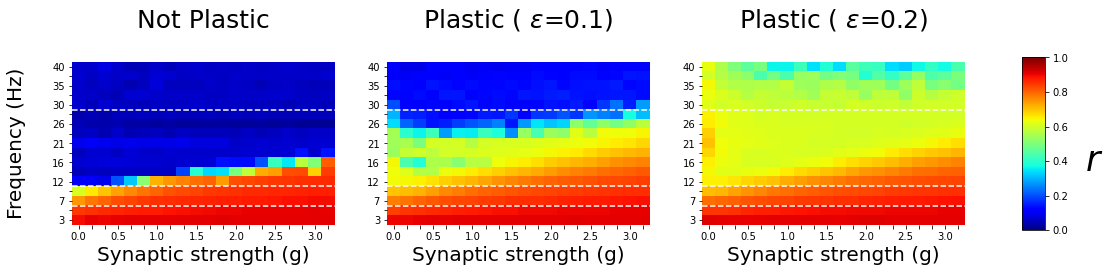

<Figure size 432x288 with 0 Axes>

In [11]:
# Load simulation results

f = sim_res_dir + '/Fig5__Epsilon0p0__OPvsGandOMEGAvsOP0p0.txt'
df_Fig5__Epsilon0p0__OPvsGandOMEGAvsOP0p0 = pd.read_csv(f,sep='\t',header=None)
df_Fig5__Epsilon0p0__OPvsGandOMEGAvsOP0p0.columns = ['G', 'Omega', 'R']
df_Fig5__Epsilon0p0__OPvsGandOMEGAvsOP0p0.Omega*=(1/(2*pi))*100

f = sim_res_dir + '/Fig5__Epsilon0p1__OPvsGandOMEGAvsOP0p1.txt'
df_Fig5__Epsilon0p1__OPvsGandOMEGAvsOP0p1 = pd.read_csv(f,sep='\t',header=None)
df_Fig5__Epsilon0p1__OPvsGandOMEGAvsOP0p1.columns =   ['G', 'Omega', 'R']
df_Fig5__Epsilon0p1__OPvsGandOMEGAvsOP0p1.Omega*=(1/(2*pi))*100

f = sim_res_dir + '/Fig5__Epsilon0p2__OPvsGandOMEGAvsOP0p2.txt'
df_Fig5__Epsilon0p2__OPvsGandOMEGAvsOP0p2 = pd.read_csv(f,sep='\t',header=None)
df_Fig5__Epsilon0p2__OPvsGandOMEGAvsOP0p2.columns =    ['G', 'Omega', 'R']
df_Fig5__Epsilon0p2__OPvsGandOMEGAvsOP0p2.Omega*=(1/(2*pi))*100


# Make figure

fig, ax = plt.subplots(ncols=3, figsize=(16,3))

df = df_Fig5__Epsilon0p0__OPvsGandOMEGAvsOP0p0.set_index(['G', 'Omega']).unstack('G')['R']
df = df.sort_index(0,ascending=False)
df = df.iloc[:,1:]
df = df.loc[40:0]


# Make ticklabels

xtls = []
for a in np.arange(0,3.5,0.5):
    xtls.append(a)
    xtls+= ['', '']
    
tmps = ['%1.0f' %(i+1) for i in df.index.values]

ytls = []
odd=True
for t in tmps:
    if odd==True:
        ytls.append(t)
    else:
        ytls.append('')
    odd = not(odd)
ytls    
    
# Panel 1
a = ax[0]
df = df_Fig5__Epsilon0p0__OPvsGandOMEGAvsOP0p0.set_index(['G', 'Omega']).unstack('G')['R']
df = df.sort_index(0,ascending=False)
df = df.iloc[:,1:]
df = df.loc[40:0]
labs = ['%1.0f' %i for i in df.index.values]
sns.heatmap(df,cmap='jet',yticklabels=labs,ax=a,vmin=0,vmax=1,cbar=False)
a.axhline(y=5.0, linestyle='--', c='white')
a.axhline(y=13, linestyle='--', c='white')
a.axhline(y=15, linestyle='--', c='white')
a.set_title('Not Plastic\n',fontsize=25)
a.set_xticklabels(xtls,rotation=0)
a.set_yticklabels(ytls,rotation=0)
a.set_xlabel('Synaptic strength (g)',fontsize=20)
a.set_ylabel('Frequency (Hz)\n',fontsize=20)

# Panel 2
a = ax[1]
df = df_Fig5__Epsilon0p1__OPvsGandOMEGAvsOP0p1.set_index(['G', 'Omega']).unstack('G')['R']
df = df.sort_index(0,ascending=False)
df = df.iloc[:,1:]
df = df.loc[40:0]
labs = ['%1.0f' %i for i in df.index.values]
sns.heatmap(df,cmap='jet',yticklabels=labs,ax=a,vmin=0,vmax=1,cbar=False)
a.axhline(y=5.0, linestyle='--', c='white')
a.axhline(y=13, linestyle='--', c='white')
a.axhline(y=15, linestyle='--', c='white')
a.set_xticklabels(xtls,rotation=0)
a.set_yticklabels(ytls,rotation=0)
a.set_xlabel('Synaptic strength (g)',fontsize=20)
a.set_title("Plastic ( $\epsilon$=0.1)\n",fontsize=25)#,usetex=True)
a.set_ylabel('')

# Panel 3
a = ax[2]
df = df_Fig5__Epsilon0p2__OPvsGandOMEGAvsOP0p2.set_index(['G', 'Omega']).unstack('G')['R']
df = df.sort_index(0,ascending=False)
df = df.iloc[:,1:]
df = df.loc[40:0]
labs = ['%1.0f' %i for i in df.index.values]
hm = sns.heatmap(df,cmap='jet',yticklabels=labs,ax=a,vmin=0,vmax=1,cbar=False)
a.axhline(y=5.0, linestyle='--', c='white')
a.axhline(y=13, linestyle='--', c='white')
a.axhline(y=15, linestyle='--', c='white')
a.set_xticklabels(xtls,rotation=0)
a.set_yticklabels(ytls,rotation=0)
a.set_title("Plastic ( $\epsilon$=0.2)\n",fontsize=25)#,usetex=True)
a.set_xlabel('Synaptic strength (g)',fontsize=20)
a.set_ylabel('')#,fontsize=20)

# Colorbar
divider = make_axes_locatable(a)
cax = plt.axes([0.95, 0.1, 0.02, 0.8])
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('    $r$',fontsize=35,rotation=0)


plt.show();

plt.tight_layout();

> Figure 5: Order parameter as a function of the synaptic gain (g) of connections and frequency bands (δ,α ,β γ) for increasing the myelination rate (ϵ). In each case, the order parameter r was measured across independent trials, for increasing synaptic gain g and local oscillation frequency. As the myelination rate is increased from ϵ=0 to ϵ=0.2 (i.e. from the not plastic to the plastic case) the phase locking region increases. In absence of adaptive myelination, phase locking is achieved only for strong coupling and for low frequencies. When ϵ is increased, the synchronization regime becomes more prevalent, not only for higher coupling gains, but also across frequency bands and for weaker synaptic coupling A. ϵ=0.0; B. ϵ=0.1; C. ϵ=0.2. Here α_c=1. 

## Figure 6

In [12]:
f = sim_res_dir + '/Fig6__Kuramoto_e0p2_a0p001_damage__SubSampledOrderParamaterPLI.txt'
df_Fig6__Kuramoto_e0p2_a0p001_damage__SubSampledOrderParamaterPLI = pd.read_csv(f,sep='\t',header=None)
df_Fig6__Kuramoto_e0p2_a0p001_damage__SubSampledOrderParamaterPLI.columns = ['t', 'theta']

f = sim_res_dir + '/Fig6__Kuramoto_e0p0_a0p001_damage__SubSampledOrderParamaterPLI.txt'
df_Fig6__Kuramoto_e0p0_a0p001_damage__SubSampledOrderParamaterPLI = pd.read_csv(f,sep='\t',header=None)
df_Fig6__Kuramoto_e0p0_a0p001_damage__SubSampledOrderParamaterPLI.columns = ['t', 'theta']


f = sim_res_dir + '/Fig6__Kuramoto_InsultVsEpsilon__OPvsINSULTvsEPSILON.txt'
df_Fig6__Kuramoto_InsultVsEpsilon__OPvsINSULTvsEPSILON = pd.read_csv(f,sep='\t',header=None)

f = '../data/sim_results/Fig6__Kuramoto_e0p2_a0p001_damage__SubSampledConductionSpeeds_v2.txt'
df_Fig6__Kuramoto_e0p2_a0p001_damage__SubSampledConductionSpeeds = pd.read_csv(f,sep='\t',header=None)

Text(33.0, 0.5, 'Insult index $\\gamma$')

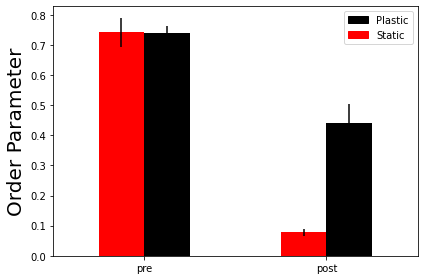

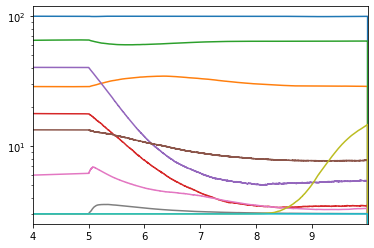

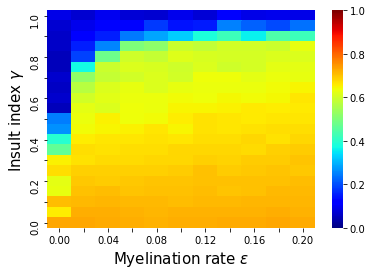

In [13]:
# Panel B

df = df_Fig6__Kuramoto_e0p2_a0p001_damage__SubSampledOrderParamaterPLI.copy()
df_plastic = df.set_index('t')
df = df_Fig6__Kuramoto_e0p0_a0p001_damage__SubSampledOrderParamaterPLI.copy()
df_noplastic = df.set_index('t')
_df = pd.concat({'plastic': df_plastic, 'noplastic': df_noplastic})
mn_pre = _df.unstack(0).loc[0:60*60*5].mean()
mn_post = _df.unstack(0).loc[60*60*5:(60*60*5)+(60*60*5)].mean()
std_pre = _df.unstack(0).loc[0:60*60*5].std()
std_post = _df.unstack(0).loc[60*60*5:(60*60*5)+(60*60*5)].std()
df_mn = pd.concat({'pre': mn_pre, 'post': mn_post})
df_std = pd.concat({'pre': std_pre, 'post': std_post})
df_mn_us = df_mn.unstack(0).T
df_std_us = df_std.unstack(0).T

fig, ax = plt.subplots();

df_mn_us['theta'].loc[['pre', 'post']].plot(kind='bar',color=['Red','Black'],
                                            yerr=df_std_us['theta'].loc[['pre', 'post']],
                                            ax=ax,rot=0);
ax.set_ylabel('Order Parameter',fontsize=20)
red_patch = mpatches.Patch(color='Red', label='Static');
black_patch = mpatches.Patch(color='Black', label='Plastic');
plt.legend(handles=[black_patch, red_patch],loc='upper right');
plt.tight_layout();




# Panel C

df = df_Fig6__Kuramoto_e0p2_a0p001_damage__SubSampledConductionSpeeds.copy()
df = df.set_index(0)
df_hrs = df.index / 60 / 60
df.index = df_hrs
df.index.names = ['']
df.head()
df.loc[4:].plot(logy=True,legend=False)


# Panel D

df = df_Fig6__Kuramoto_InsultVsEpsilon__OPvsINSULTvsEPSILON.copy()
df.columns = ['Epsilon', 'Insult', 'R']
df = df.set_index(['Epsilon', 'Insult']).unstack('Insult')['R']
df = df.T 
df = df.sort_index(0,ascending=False)
df = df.iloc[:,:11]

xtls = []
for a in np.flipud(np.arange(0,1.2,0.2)):
    #for a in np.arange(0,3.5,0.5):
    xtls.append('%0.1f' %a)
    xtls+= ['']
tmps = ['%0.2f' %(i) for i in df.columns.values]
ytls = []
odd=True
for t in tmps:
    if odd==True:
        ytls.append(t)
    else:
        ytls.append('')
    odd = not(odd)
ytls    

fig, ax = plt.subplots()
sns.heatmap(df,cmap='jet',vmin=0,vmax=1.)
ax.set_yticklabels(xtls)
ax.set_xticklabels(ytls)
ax.set_xlabel('Myelination rate $\epsilon$', fontsize=15)
ax.set_ylabel('Insult index $\gamma$', fontsize=15)

> Figure 6: Network resilience to sudden and diffuse decrease in connectivity. A. To examine the influence of adaptive myelination on network structure dynamics, we considered a random and spatially diffuse injury scaled by the insult index . Spontaneous changes to network connectivity and phase shuffling was performed after 5 hours of network evolution. We then examined the oscillatory properties and compared the synchronization properties of the network before and after injury, once network conduction velocities have adapted. B. Adaptive myelination allows the system to maintain a high degree of phase-locked synchrony, even after an injury which caused the destruction of 80% of the connections. The order parameter, in case of plastic conduction velocities, remains high despite the insult applied to the network, indicative of oscillatory resilience.   C. Once a sudden decrease in synaptic coupling occurs, the dynamics of the conduction velocities (for preserved connections) is altered and a change in overall conduction velocity statistics takes place. D. The myelination rate compensates for an increased degree of injury to preserve oscillatory synchrony. The more significant the connectivity insult, the more myelination is required to keep the order parameter high – and hence keep the remaining networks synchronized. Here, a frequency of o=65rad/s10Hz was used, g=1,  c=1.

## Figure 7

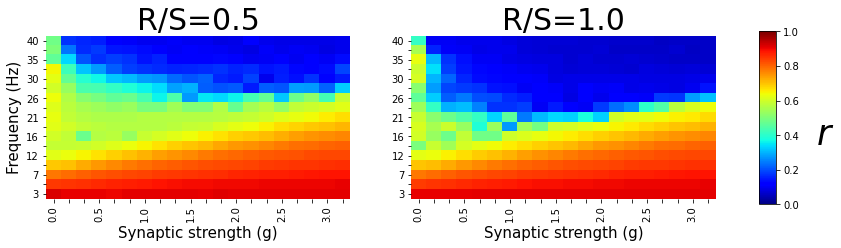

In [14]:
# Load data

f = sim_res_dir + '/Fig7__Epsilon0p2_sr0p5__OPvsGandOMEGAvsOP0p2.txt'
df_Fig7__Epsilon0p2_sr0p5__OPvsGandOMEGAvsOP0p2 = pd.read_csv(f,sep='\t',header=None)
df_Fig7__Epsilon0p2_sr0p5__OPvsGandOMEGAvsOP0p2.columns = ['G', 'OMEGA', 'R']
df_Fig7__Epsilon0p2_sr0p5__OPvsGandOMEGAvsOP0p2.OMEGA*=(1/(2*pi))*100

f = sim_res_dir + '/Fig7__Epsilon0p2_sr1p0__OPvsGandOMEGAvsOP0p2.txt'
df_Fig7__Epsilon0p2_sr1p0__OPvsGandOMEGAvsOP0p2 = pd.read_csv(f,sep='\t',header=None)
df_Fig7__Epsilon0p2_sr1p0__OPvsGandOMEGAvsOP0p2.columns = ['G', 'OMEGA', 'R']
df_Fig7__Epsilon0p2_sr1p0__OPvsGandOMEGAvsOP0p2.OMEGA*=(1/(2*pi))*100


# Make figure

fig, ax = plt.subplots(ncols=2, figsize=(12,3))

a = ax[0]
df = df_Fig7__Epsilon0p2_sr0p5__OPvsGandOMEGAvsOP0p2.set_index(['G', 'OMEGA']).unstack('OMEGA').T.loc['R']
df = df.sort_index(0,ascending=False)
df = df.iloc[:,1:]
df = df.loc[40:0]
labs = ['%1.0f' %i for i in df.index.values]
sns.heatmap(df,cmap='jet',yticklabels=labs,ax=a,vmin=0,vmax=1,cbar=False)

a = ax[1]
df = df_Fig7__Epsilon0p2_sr1p0__OPvsGandOMEGAvsOP0p2.set_index(['G', 'OMEGA']).unstack('OMEGA').T.loc['R']
df = df.sort_index(0,ascending=False)
df = df.iloc[:,1:]
df = df.loc[40:0]
labs = ['%1.0f' %i for i in df.index.values]
sns.heatmap(df,cmap='jet',yticklabels=labs,ax=a,vmin=0,vmax=1,cbar=False)


xtls = []
for a in np.arange(0,3.5,0.5):
    xtls.append(a)
    xtls+= ['', '']
    
tmps = ['%1.0f' %(i+1) for i in df.index.values]

ytls = []
odd=True
for t in tmps:
    if odd==True:
        ytls.append(t)
    else:
        ytls.append('')
    odd = not(odd)
ytls    
    
ax[0].set_xticklabels(xtls)
ax[0].set_yticklabels(ytls)

ax[1].set_xticklabels(xtls)
ax[1].set_yticklabels(ytls)

ax[0].set_ylabel('Frequency (Hz)', fontsize=15)
ax[1].set_ylabel('')

ax[0].set_xlabel('Synaptic strength (g)', fontsize=15)
ax[1].set_xlabel('Synaptic strength (g)', fontsize=15)

ax[0].set_title('R/S=0.5',fontsize=30)
ax[1].set_title('R/S=1.0',fontsize=30)


# Colorbar
a = ax[0]

divider = make_axes_locatable(a)
cax = plt.axes([0.95, 0.1, 0.02, 0.8])
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('    $r$',fontsize=35,rotation=0)


> Figure 7: Investigating the effects of myelin retraction and stabilization on phase synchronization. A. When bidirectional myelin remodelling is considered, both phase retraction and stabilization between oscillatory nodes combine to establish and maintain network-wide phase synchronization. If the phase offset between two connected oscillators is positive (red), the phase precession causes a retraction of myelin and hence the conduction velocity decreases. If the phase offset between two connected oscillators is negative (blue), the phase lag causes a stabilization of myelin and hence the conduction velocity increases. B-C. The effect of modifying the ratio of myelin retraction (R) to stabilization (S), on the Kuramoto order parameter (r), measured across independent trials, as a function of increasing synaptic gain (g) of connections and various frequency bands (𝛿, 𝛼, 𝛽, 𝛾). When the rate of retraction is half the rate of stabilization (R/S =0.5) there is more myelin being formed than being lost, overall. This results in more phase-locking across the network, compared to when the rate of myelin retraction is higher (R/S =1.0). In the case of the rates of myelin retraction and stabilization being equal (R/S =1.0), there is less phase-locking observed in the higher frequency bands across all synaptic gains. However the phase-locking still takes place over a wide range of synaptic coupling. Parameters are as in Figure 5. 